<img src="files\images\bulldozer.jpg"/>


# Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

Since we're trying to predict a number, this kind of problem is known as a **regression problem**.

The data and evaluation metric we'll be using (**root mean square log error or RMSLE**) is from the <a href="https://www.kaggle.com/c/bluebook-for-bulldozers/overview">Kaggle Bluebook for Bulldozers competition</a>.

The techniques used in here have been inspired and adapted from <a href="https://course18.fast.ai/ml">the fast.ai machine learning course</a>.

## What we'll end up with

Since we already have a dataset, we'll approach the problem with the following machine learning modelling framework.

<img src="files\images\2.png"/>

6 Step Machine Learning Modelling Framework (<a href="https://whimsical.com/6-step-field-guide-to-machine-learning-projects-flowcharts-9g65jgoRYTxMXxDosndYTB">read more</a>)

To work through these topics, we'll use pandas, Matplotlib and NumPy for data anaylsis, as well as, Scikit-Learn for machine learning and modelling tasks.

<img src="files\images\4.png"/>

                            Tools which can be used for each step of the machine learning modelling process.

We'll work through each step and by the end of the notebook, we'll have a trained machine learning model which predicts the sale price of a bulldozer given different characteristics about it.

## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

>How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the <a href="https://www.kaggle.com/c/bluebook-for-bulldozers/data">dataset from Kaggle</a>, you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:

1. **Train.csv**- Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including SalePrice which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, <a href="https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation">Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)</a>. As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the <a href="https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard">Kaggle leaderboard</a>.

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can <a href="https://github.com/mrdbourke/zero-to-mastery-ml/blob/master/section-3-structured-data-projects/end-to-end-bluebook-bulldozer-price-regression.ipynb">download this file directly from the Kaggle competition page</a> (account required) or view it on Google Sheets.

With all of this being known, let's get started!

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

### Importing the data and preparing it for modelling

In [343]:
# Import data analysis tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

Now we've got our tools for data analysis ready, we can import the data and start to explore it.

For this project, we've <a href="https://www.kaggle.com/c/bluebook-for-bulldozers/data">downloaded the data from Kaggle</a> and stored it under the file path `"../data/"`.

In [344]:
# Import the training and validation set
df = pd.read_csv("data/TrainAndValid.csv",
                 low_memory=False) # We were given an error, and this attribute lets it import without errors

In [345]:
# Check missing values
df.isna().sum()


SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

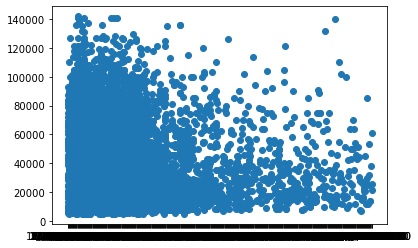

In [346]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:10000], df["SalePrice"][:10000]);

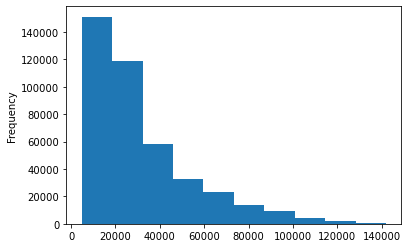

In [347]:
df.SalePrice.plot.hist();

In [348]:
# No parse_dates... check dtyp of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

### Parsing dates
When working with time series data, it's a good idea to make sure any date data is the format of a <a href="https://docs.python.org/3/library/datetime.html">datetime object</a>datetime object (a Python data type which encodes specific information about dates).

In [349]:
# Import data again but this time with parse dates
df = pd.read_csv("data/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [350]:
df.saledate.dtype

dtype('<M8[ns]')

In [351]:
# With parse_dates... check dtype of "saledate"
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

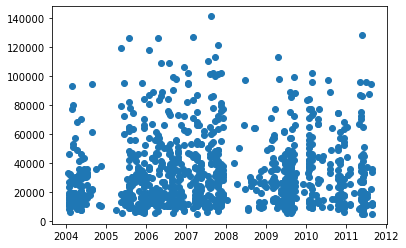

In [352]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [353]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [354]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [355]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate
As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [356]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame
Since we're going to be manipulating the data, we'll make a copy of the original DataFrame and perform our changes there.

This will keep the original DataFrame in tact if we need it again.

In [357]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy()

### Add datetime parameters for saledate column
Why?

So we can enrich our dataset with as much information as possible.

Because we imported the data using `read_csv()` and we asked pandas to parse the dates using `parase_dates=["saledate"]`, we can now access the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html">different datetime attributes</a> of the `saledate` column.

In [358]:
# Add datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

df_tmp.head().T
# Drop original saledate
df_tmp.drop("saledate", axis=1, inplace=True)

We could add more of these style of columns, such as, whether it was the start or end of a quarter but these will do for now.

**Challenge**: See what other <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html">datetime attributes</a> you can add to `df_tmp` using a similar technique to what we've used above. Hint: check the bottom of the pandas.DatetimeIndex docs.

In [359]:
# Check the different values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling
We've explored our dataset a little as well as enriched it with some datetime attributes, now let's try to model.

Why model so early?

We know the evaluation metric we're heading towards. We could spend more time doing exploratory data analysis (EDA), finding more out about the data ourselves but what we'll do instead is use a machine learning model to help us do EDA.

Remember, one of the biggest goals of starting any new machine learning project is reducing the time between experiments.

Following the <a href="https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html">Scikit-Learn machine learning map</a>, we find a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor">RandomForestRegressor()</a> might be a good candidate.

In [360]:
# This won't work since we have got some missing numbers and categories
from sklearn.ensemble import RandomForestRegressor

# Instatiate the model

model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

ValueError: could not convert string to float: 'Low'

In [361]:
# Check for missing categories and different datatypes
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,TD20,TD20,NaN,NaN,NaN,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Direct Drive,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,A66,A66,NaN,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,D7G,D7,G,NaN,NaN,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,A62,A62,NaN,NaN,NaN,NaN,Wheel Loader - Unidentified,Florida,WL,Wheel Loader,NaN,EROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,D3B,D3,B,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,D38E,D38,E,NaN,NaN,NaN,"Track Type Tractor, Dozer - 75.0 to 85.0 Horse...",California,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,Multi Shank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,2064,2064,NaN,NaN,NaN,NaN,Skid Steer Loader - 1751.0 to 2201.0 Lb Operat...,California,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,337G,337,G,NaN,NaN,Mini,"Hydraulic Excavator, Track - 5.0 to 6.0 Metric...",California,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,12G,12,G,NaN,NaN,NaN,Motorgrader - 130.0 to 145.0 Horsepower,California,MG,Motor Graders,No,OROPS,NaN,NaN,NaN,NaN,No

In the format it's in, it's still good to be worked with, let's save it to file and reimport it so we can continue on.

## Save Processed Data

In [362]:
# Save preprocessed data
df_tmp.to_csv("data/train_tmp.csv", index=False)

In [363]:
# Import preprocessed data
df_tmp = pd.read_csv("data/train_tmp.csv", low_memory=False)

df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


### Convert strings to categories
One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

To do this we can use the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality">pandas types API</a> which allows us to interact and manipulate the types of data.

In [364]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [365]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [366]:
# These columns contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [367]:
# If you're wondering what df.items() does, let's use a dictionary as an example
random_dict = {"key1": "hello",
               "key2": "world!"}

for key, value in random_dict.items():
    print(f"This is a key: {key}")
    print(f"This is a value: {value}")

This is a key: key1
This is a value: hello
This is a key: key2
This is a value: world!


In [368]:
# This will turn all of the string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [369]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


All of our data is categorical and thus we can now turn the categories into numbers, however it's still missing values...

In [370]:
# Check missing data as a percentage
df_tmp.isnull().sum()/len(df_tmp)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

In [371]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

## Splitting data into train/valid sets

In [372]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,TD20,NaN,NaN,NaN,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Direct Drive,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,A66,NaN,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,D7,G,NaN,NaN,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,A62,NaN,NaN,NaN,NaN,Wheel Loader - Unidentified,Florida,WL,Wheel Loader,NaN,EROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,D3,B,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


According to the <a href="https://www.kaggle.com/c/bluebook-for-bulldozers/data">Kaggle data page</a>, the validation set and test set are split according to dates.

This makes sense since we're working on a time series problem.

E.g. using past events to try and predict future events.

Knowing this, randomly splitting our data into train and test sets using something like train_test_split() wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In our case:

* Training = all samples up until 2011
* Valid = all samples form January 1, 2012 - April 30, 2012
* Test = all samples from May 1, 2012 - November 2012

For more on making good training, validation and test sets, check out the post <a href="https://www.fast.ai/2017/11/13/validation-sets/">How (and why) to create a good validation set</a> by Rachel Thomas.

In [373]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [374]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [375]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 56), (401125,), (11573, 56), (11573,))

In [376]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

In [377]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 0 to 401124
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   401125 non-null  int64   
 1   SalePrice                 401125 non-null  float64 
 2   MachineID                 401125 non-null  int64   
 3   ModelID                   401125 non-null  int64   
 4   datasource                401125 non-null  int64   
 5   auctioneerID              380989 non-null  float64 
 6   YearMade                  401125 non-null  int64   
 7   MachineHoursCurrentMeter  142765 non-null  float64 
 8   UsageBand                 69639 non-null   category
 9   fiModelDesc               401125 non-null  category
 10  fiBaseModel               401125 non-null  category
 11  fiSecondaryDesc           263934 non-null  category
 12  fiModelSeries             56908 non-null   category
 13  fiModelDescriptor         719

Excellent, our processed DataFrame has the columns we added to it but it's still missing values.

In [378]:
# Check missing values
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Fill missing values
From our experience with machine learning models. We know two things:

1. All of our data has to be numerical
2. There can't be any missing values
And as we've seen using `df_tmp.isna().sum()` our data still has plenty of missing values.

Let's fill them.

### Filling numerical values first
We're going to fill any column with missing values with the median of that column.

In [379]:
for label, content in X_train.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [380]:
df_tmp.ModelID

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [381]:
# Check for which numeric columns have null values

In [382]:
X_valid.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
401125,4449186,2318824,26964,173,99.0,1996,0.0,NaN,D65E12,D65,E,12,NaN,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Michigan,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN,2012,1,1,6,1
401126,1222855,531393,23926,121,3.0,1000,8145.0,Low,12HNA,12,H,NaN,NaN,NaN,Motorgrader - 130.0 to 145.0 Horsepower,Florida,MG,Motor Graders,No,OROPS,NaN,NaN,NaN,NaN,None or Unspecified,NaN,None or Unspecified,14',High Profile,No,Base + 1 Function,None or Unspecified,None or Unspecified,Yes,None or Unspecified,"17.5""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,4,2,4
401127,6258613,1810917,13260,149,99.0,2000,24.0,Low,590SUPER LII,590,SUPER L,II,NaN,NaN,Backhoe Loader - 15.0 to 16.0 Ft Standard Digg...,Iowa,BL,Backhoe Loaders,Four Wheel Drive,OROPS,None or Unspecified,None or Unspecified,No,Extended,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,1,4,2,4
401128,6282680,1543404,1830,149,99.0,2004,4373.0,Medium,120C,120,C,NaN,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Mississippi,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,24 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2012,1,4,2,4
401129,6282759,1863077,11390,149,99.0,2006,3467.0,Medium,160CLC,160,C,NaN,LC,Small,"Hydraulic Excavator, Track - 14.0 to 16.0 Metr...",Mississippi,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2012,1,4,2,4


In [383]:
def nullValues(data_set):
    for label, content in data_set.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                return(print(label))

In [384]:
nullValues(X_train), nullValues(y_train), nullValues(X_valid), nullValues(y_valid)

auctioneerID
MachineHoursCurrentMeter


(None, None, None, None)

Why add a binary column indicating whether the data was missing or not?

We can easily fill all of the missing numeric values in our dataset with the median. However, a numeric value may be missing for a reason. In other words, absence of evidence may be evidence of absence. Adding a binary column which indicates whether the value was missing or not helps to retain this information.

In [385]:
# Fill numeric rows with the median
def nullValuesFill(data_set_fill): # Create a function to perform this on our train and validate datasets
    for label, content in data_set_fill.items():
            if pd.api.types.is_numeric_dtype(content):
                if pd.isnull(content).sum():
                    # Add a binary column which tells is fhte data was missing or not
                    data_set_fill[label+"_is_missing"] = pd.isnull(content)
                    # Fill missing numeric values with median since it is more robust than the mean
                    data_set_fill[label] = content.fillna(content.median())        

In [386]:
nullValuesFill(X_train), nullValuesFill(y_train), nullValuesFill(X_valid), nullValuesFill(y_valid)

(None, None, None, None)

In [387]:
# Check if there are any null numeric values
def check_for_null(data_set_nulls):    
    for label, content in data_set_nulls.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                print(label)   

In [388]:
check_for_null(X_train), check_for_null(X_valid), check_for_null(y_train), check_for_null(y_valid)

(None, None, None, None)

In [389]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,NaN,TD20,TD20,NaN,NaN,NaN,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Direct Drive,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17,False,True
1,1821514,1194089,10150,132,99.0,1980,0.0,NaN,A66,A66,NaN,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31,False,True
2,1505138,1473654,4139,132,99.0,1978,0.0,NaN,D7G,D7,G,NaN,NaN,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31,False,True
3,1671174,1327630,8591,132,99.0,1980,0.0,NaN,A62,A62,NaN,NaN,NaN,NaN,Wheel Loader - Unidentified,Florida,WL,Wheel Loader,NaN,EROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31,False,True
4,1329056,1336053,4089,132,99.0,1984,0.0,NaN,D3B,D3,B,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31,False,True


In [390]:
X_valid.isna().sum()

SalesID                                    0
MachineID                                  0
ModelID                                    0
datasource                                 0
auctioneerID                               0
YearMade                                   0
MachineHoursCurrentMeter                   0
UsageBand                               7542
fiModelDesc                                0
fiBaseModel                                0
fiSecondaryDesc                         3536
fiModelSeries                           9814
fiModelDescriptor                       8676
ProductSize                             5830
fiProductClassDesc                         0
state                                      0
ProductGroup                               0
ProductGroupDesc                           0
Drive_System                            8847
Enclosure                                  9
Forks                                   5935
Pad_Type                                9611
Ride_Contr

### Filling and turning categorical variables to numbers
Now we've filled the numeric values, we'll do the same with the categorical values at the same time as turning them into numbers.

In [391]:
# Check columns which *are not* numeric, we have two sets, X_train, X_valid
def cat_val_check(dataset):    
    for label, content in dataset.items():
        if not pd.api.types.is_numeric_dtype(content):
            print(label)
            
cat_val_check(X_train)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [392]:
cat_val_check(X_valid)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [393]:
# Turn categorical vairables into numbers and fill missing
def cat_num_fill(dataset):
    for label, content in dataset.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Add binary column to indicate whether sample had missing value
            dataset[label+"_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add +1
            dataset[label] = pd.Categorical(content).codes+1


In [394]:
cat_num_fill(X_train)

In [395]:
cat_num_fill(X_valid)

In [396]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 0 to 401124
Columns: 102 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(2), int16(4), int64(10), int8(40)
memory usage: 75.7 MB


In [397]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,17,1,17,False,True,True,False,False,True,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,59,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,5,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [398]:
X_valid.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 101, dtype: int64

Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

Let's reinstantiate our trusty <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html">RandomForestRegressor</a>.

This will take a few minutes which is too long for interacting with it. So what we'll do is create a subset of rows to work with.

In [399]:
X_valid.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
401125,4449186,2318824,26964,173,99.0,1996,0.0,0,2269,711,50,56,0,2,50,22,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,6,0,0,2012,1,1,6,1,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
401126,1222855,531393,23926,121,3.0,1000,8145.0,2,85,19,61,0,0,0,31,9,2,2,3,6,0,0,0,0,5,0,1,3,1,1,5,1,2,2,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,True,True,True,False,False,False,False,False,False,True,True,True,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
401127,6258613,1810917,13260,149,99.0,2000,24.0,2,1115,328,137,98,0,0,3,15,1,1,2,6,1,2,1,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
401128,6282680,1543404,1830,149,99.0,2004,4373.0,3,64,20,31,0,0,6,8,24,4,4,0,3,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,7,29,3,2,1,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,True,True,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
401129,6282759,1863077,11390,149,99.0,2006,3467.0,3,139,41,31,0,65,6,9,24,4,4,0,3,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,19,29,3,2,1,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True


In [400]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,17,1,17,False,True,True,False,False,True,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,59,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,5,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [401]:
set(X_train.columns) - set(X_valid.columns)

{'auctioneerID_is_missing'}

In [402]:
X_valid.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
401125,4449186,2318824,26964,173,99.0,1996,0.0,0,2269,711,50,56,0,2,50,22,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,6,0,0,2012,1,1,6,1,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
401126,1222855,531393,23926,121,3.0,1000,8145.0,2,85,19,61,0,0,0,31,9,2,2,3,6,0,0,0,0,5,0,1,3,1,1,5,1,2,2,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,True,True,True,False,False,False,False,False,False,True,True,True,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
401127,6258613,1810917,13260,149,99.0,2000,24.0,2,1115,328,137,98,0,0,3,15,1,1,2,6,1,2,1,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
401128,6282680,1543404,1830,149,99.0,2004,4373.0,3,64,20,31,0,0,6,8,24,4,4,0,3,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,7,29,3,2,1,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,True,True,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
401129,6282759,1863077,11390,149,99.0,2006,3467.0,3,139,41,31,0,65,6,9,24,4,4,0,3,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,19,29,3,2,1,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True


In [403]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,17,1,17,False,True,True,False,False,True,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,59,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,5,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [404]:
# Match test dataset columns to training dataset
X_valid["auctioneerID_is_missing"] = False
X_valid.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
401125,4449186,2318824,26964,173,99.0,1996,0.0,0,2269,711,50,56,0,2,50,22,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,6,0,0,2012,1,1,6,1,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True,False
401126,1222855,531393,23926,121,3.0,1000,8145.0,2,85,19,61,0,0,0,31,9,2,2,3,6,0,0,0,0,5,0,1,3,1,1,5,1,2,2,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,True,True,True,False,False,False,False,False,False,True,True,True,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
401127,6258613,1810917,13260,149,99.0,2000,24.0,2,1115,328,137,98,0,0,3,15,1,1,2,6,1,2,1,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
401128,6282680,1543404,1830,149,99.0,2004,4373.0,3,64,20,31,0,0,6,8,24,4,4,0,3,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,7,29,3,2,1,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,True,True,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False
401129,6282759,1863077,11390,149,99.0,2006,3467.0,3,139,41,31,0,65,6,9,24,4,4,0,3,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,19,29,3,2,1,0,0,0,0,0,2012,1,4,2,4,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False


In [405]:
len(X_train)

401125

In [406]:
%%time
# Instatiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# Fit the model
model.fit(X_train, y_train)

Wall time: 1min 34s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [407]:
# Score the model
model.score(X_train, y_train)

0.9875150955953674

**Question**: Why is this metric not reliable?

## Building an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, <a href="https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation">the evaluation function</a> they use is root mean squared log error (RMSLE).

**RMSLE** = generally you don't care as much if you're off by `$10` as much as you'd care if you were off by `10%`, you care more about ratios rather than differences. 

**MAE** (mean absolute error) is more about exact differences.

It's important to understand the evaluation metric you're going for.

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error">mean_squared_log_error</a> (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

We'll also calculate the MAE and R^2 for fun.

In [408]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

## Testing our model on a subset (to tune the hyperparameters)

Retraing an entire model would take far too long to continuing experimenting as fast as we want to.

So what we'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.

If you're experiments are taking longer than 10-seconds (give or take how long you have to wait), you should be trying to speed things up. You can speed things up by sampling less data or using a faster computer.

In [409]:
# This takes too long...

# %%time
# # Retrain a model on training data
# model.fit(X_train, y_train)
# show_scores(model)

Depending on your computer (mine is a MacBook Pro), making calculations on ~400,000 rows may take a while...

Let's alter the number of samples each `n_estimator` in the `RandomForestRegressor` see's using the `max_samples` parameter.

In [410]:
# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,
                              max_samples=10000)

Setting `max_samples` to 10000 means every n_estimator (default 100) in our `RandomForestRegressor` will only see 10000 random samples from our DataFrame instead of the entire 400,000.

In other words, we'll be looking at 40x less samples which means we'll get faster computation speeds but we should expect our results to worsen (simple the model has less samples to learn patterns from).

In [411]:
%%time
# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train, y_train)

Wall time: 4.64 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [412]:
pd.set_option('display.max_columns', None)

In [413]:
X_test = pd.read_csv("data/Test.csv",
                      parse_dates=["saledate"])
X_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [414]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,17,1,17,False,True,True,False,False,True,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,59,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,5,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [415]:
y_train.head()

0     9500.0
1    14000.0
2    50000.0
3    16000.0
4    22000.0
Name: SalePrice, dtype: float64

In [416]:
show_scores(model)

C:\Users\daver\Desktop\ZTM\ml\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


{'Training MAE': 5549.844831785605,
 'Valid MAE': 7493.941628791152,
 'Training RMSLE': 0.25748438643554566,
 'Valid RMSLE': 0.31300396772125655,
 'Training R^2': 0.8612423746929869,
 'Valid R^2': 0.8209855380197644}

In [417]:
set(X_train.columns) - set(X_valid.columns)

set()

That took far less time than the model with all the data.

With this, let's try tune some hyperparameters.

## Hyperparameter tuning with RandomizedSearchCV

You can increase `n_iter` to try more combinations of hyperparameters but in our case, we'll try 20 and see where it gets us.

Remember, we're trying to reduce the amount of time it takes between experiments.

In [418]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 4min 36s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [419]:
# Find the best parameters from the RandomizedSearch
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 10,
 'min_samples_leaf': 13,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [420]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

C:\Users\daver\Desktop\ZTM\ml\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


{'Training MAE': 6588.59186228563,
 'Valid MAE': 9639.318356152311,
 'Training RMSLE': 0.2958939088663635,
 'Valid RMSLE': 0.407477717216636,
 'Training R^2': 0.8089964759412611,
 'Valid R^2': 0.7372552651294548}

## Train a model with the best parameters

In a model I prepared earlier, I tried 100 different combinations of hyperparameters (setting `n_iter` to 100 in `RandomizedSearchCV`) and found the best results came from the ones you see below.

Note: This kind of search on my computer (`n_iter` = 100) took ~2-hours. So it's kind of a set and come back later experiment.

We'll instantiate a new model with these discovered hyperparameters and reset the `max_samples` back to its original value.

In [426]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=13,
                                    min_samples_split=10,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

Wall time: 40.8 s


RandomForestRegressor(max_features=0.5, min_samples_leaf=13,
                      min_samples_split=10, n_estimators=90, n_jobs=-1)

In [427]:
show_scores(ideal_model)

C:\Users\daver\Desktop\ZTM\ml\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


{'Training MAE': 4078.25898901422,
 'Valid MAE': 7299.18323380612,
 'Training RMSLE': 0.19433541338744326,
 'Valid RMSLE': 0.30853469241657755,
 'Training R^2': 0.9213129583552432,
 'Valid R^2': 0.835873828567408}

In [428]:
show_scores(rs_model)

C:\Users\daver\Desktop\ZTM\ml\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


{'Training MAE': 6588.591862285631,
 'Valid MAE': 9639.318356152311,
 'Training RMSLE': 0.2958939088663635,
 'Valid RMSLE': 0.407477717216636,
 'Training R^2': 0.8089964759412611,
 'Valid R^2': 0.7372552651294548}

With these new hyperparameters as well as using all the samples, we can see an improvement to our models performance.

You can make a faster model by altering some of the hyperparameters. Particularly by lowering `n_estimators` since each increase in `n_estimators` is basically building another small model.

However, lowering of `n_estimators` or altering of other hyperparameters may lead to poorer results.

## Make predictions on test data
Now we've got a trained model, it's time to make predictions on the test data.

Remember what we've done.

Our model is trained on data prior to 2011. However, the test data is from May 1 2012 to November 2012.

So what we're doing is trying to use the patterns our model has learned in the training data to predict the sale price of a Bulldozer with characteristics it's never seen before but are assumed to be similar to that of those in the training data.

In [429]:
X_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [430]:
test_preds = ideal_model.predict(X_test)
test_preds

C:\Users\daver\Desktop\ZTM\ml\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Low'

In [431]:
# Let's see how the model does predicting on the test data

Ahhh... the test data isn't in the same format of our other data, so we have to fix it. Let's create a function to preprocess our data.

## Preprocessing the data
Our model has been trained on data formatted in the same way as the training data.

This means in order to make predictions on the test data, we need to take the same steps we used to preprocess the training data to preprocess the test data.

Remember: Whatever you do to the training data, you have to do to the test data.

Let's create a function for doing so (by copying the preprocessing steps we used above).

In [432]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

**Question**: Where would this function break?

**Hint**: What if the test data had different missing values to the training data?

Now we've got a function for preprocessing data, let's preprocess the test dataset into the same format as our training dataset.

In [433]:
df_test = preprocess_data(X_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,25,0,0,0,2,51,1,1,4,3,2,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,5,3,3,124,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,0,0,0,4,57,46,6,6,0,1,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,7,3,0,0,0,0,0,0,0,0,0,0,0,0,3,2,2012,5,10,3,131,False,False,False,False,True,True,True,False,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,9,0,33,3,14,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,17,17,2,1,1,0,0,0,0,0,2012,5,10,3,131,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,13,0,32,3,18,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,2,17,20,2,2,2,0,0,0,0,0,2012,5,10,3,131,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,33,0,0,0,48,8,5,5,0,3,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,5,0,0,2012,5,10,3,131,False,False,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [434]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,17,1,17,False,True,True,False,False,True,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,59,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,5,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [435]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

C:\Users\daver\Desktop\ZTM\ml\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing

  warnings.warn(message, FutureWarning)


ValueError: X has 101 features, but RandomForestRegressor is expecting 102 features as input.

We've found an error and it's because our test dataset (after preprocessing) has 101 columns where as, our training dataset (`X_train`) has 102 columns (after preprocessing).

Let's find the difference.

In [436]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In this case, it's because the test dataset wasn't missing any `auctioneerID` fields.

To fix it, we'll add a column to the test dataset called `auctioneerID_is_missing` and fill it with `False`, since none of the `auctioneerID` fields are missing in the test dataset.

In [440]:
# Match test dataset columns to training dataset
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,25,0,0,0,2,51,1,1,4,3,2,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2012,5,3,3,124,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,0,0,0,4,57,46,6,6,0,1,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,7,3,0,0,0,0,0,0,0,0,0,0,0,0,3,2,2012,5,10,3,131,False,False,False,False,True,True,True,False,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,9,0,33,3,14,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,17,17,2,1,1,0,0,0,0,0,2012,5,10,3,131,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,13,0,32,3,18,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,2,17,20,2,2,2,0,0,0,0,0,2012,5,10,3,131,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,33,0,0,0,48,8,5,5,0,3,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,5,0,0,2012,5,10,3,131,False,False,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True,False


Now the test dataset matches the training dataset, we should be able to make predictions on it using our trained model.

In [441]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

C:\Users\daver\Desktop\ZTM\ml\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [442]:
test_preds

array([20058.2375667 , 19266.61520014, 51710.43578032, ...,
       14702.46064203, 19813.44098203, 27884.65241584])

When looking at the <a href="https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation">Kaggle submission requirements</a>, we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.

Let's make it.

In [443]:
# Create DataFrame compatible with Kaggle submission requirements
df_preds = pd.DataFrame() 

df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20058.237567
1,1227844,19266.615200
2,1227847,51710.435780
3,1227848,67837.482166
4,1227863,44052.304829
...,...,...
12452,6643171,42896.369344
12453,6643173,14504.749663
12454,6643184,14702.460642
12455,6643186,19813.440982


In [445]:
# Export to csv...
df_preds.to_csv("data/predictions.csv",
                index=False)

## Feature Importance

Since we've built a model which is able to make predictions. The people you share these predictions with (or yourself) might be curious of what parts of the data led to these predictions.

This is where **feature importance** comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable**.

In our case, after our model learned the patterns in the data, which bulldozer sale attributes were most important for predicting its overall sale price?

Beware: the default feature importances for random forests can lead to non-ideal results.

To find which features were most important of a machine learning model, a good idea is to search something like "[MODEL NAME] feature importance".

Doing this for our `RandomForestRegressor` leads us to find the `feature_importances_` attribute.

Let's check it out.

In [452]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.10493953e-02, 1.65080706e-02, 4.46584151e-02, 1.71909642e-03,
       1.56369734e-03, 2.07440127e-01, 1.91907337e-03, 5.81577014e-04,
       3.83579681e-02, 4.90638321e-02, 7.00509081e-02, 4.34299557e-03,
       2.24074292e-02, 1.70435212e-01, 4.39106250e-02, 2.90861554e-03,
       2.35588882e-03, 3.57454076e-03, 3.36095280e-03, 5.86636683e-02,
       2.51902313e-04, 6.75205107e-05, 1.09035581e-03, 1.31668529e-03,
       1.14075192e-03, 1.25981329e-05, 1.87477900e-03, 7.94868773e-03,
       6.46813042e-04, 1.01287605e-03, 3.32730222e-03, 5.80596937e-03,
       3.58193490e-03, 6.19959457e-04, 3.94434130e-03, 8.14385741e-03,
       5.57447783e-04, 1.33991128e-02, 1.21856167e-03, 2.92981736e-03,
       1.14648173e-03, 7.77851589e-04, 3.09858197e-03, 3.89169763e-04,
       4.98374451e-04, 1.42578712e-04, 3.12980844e-04, 1.85401111e-03,
       8.10417317e-04, 1.87479031e-04, 2.74437591e-04, 7.19145331e-02,
       2.35965319e-03, 2.39459003e-03, 1.16078431e-03, 5.98564682e-03,
      

In [451]:
# Install Seaborn package in current environment (if you don't have it)
#import sys
#!conda install --yes --prefix {sys.prefix} seaborn

In [457]:
import seaborn as sns
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

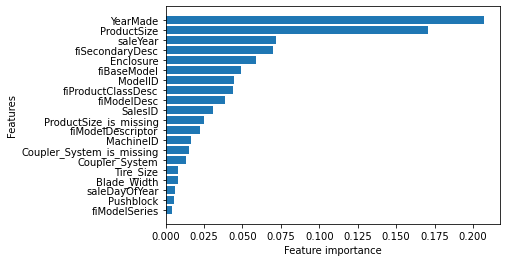

In [458]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [459]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,auctioneerID_is_missing,MachineHoursCurrentMeter_is_missing,UsageBand_is_missing,fiModelDesc_is_missing,fiBaseModel_is_missing,fiSecondaryDesc_is_missing,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,17,1,17,False,True,True,False,False,True,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,59,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,6,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1989,1,31,1,31,False,True,True,False,False,True,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,5,0,0,1989,1,31,1,31,False,True,True,False,False,False,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
